## 任務1 影像分類

In [81]:
# ---------------- 讀取資料 -------------------

import tensorflow 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras import callbacks
from sklearn.metrics import  accuracy_score

In [108]:
# ---------------- 資料前處理 -------------------
train_datagen = ImageDataGenerator(
        rescale=1./255,  # 正規化
        shear_range=0.2,  # 斜切變換
        zoom_range=0.2,  # 縮放變換
        horizontal_flip=False)  # 水平翻轉
test_datagen = ImageDataGenerator(rescale=1./255) # 正規化
# 使用flow_from_directory從資料夾中讀取訓練和驗證數據集
train_generator = train_datagen.flow_from_directory(
        r'NEU Surface Defect Database(image)\train',  # 訓練數據集的路徑
        target_size=(200, 200),  # 圖像大小
        batch_size=32,  # 批次大小
        class_mode='categorical',
        shuffle=True)  # 分類問題的類型
#validation_generator = validation_datagen.flow_from_directory(
#        r'NEU Surface Defect Database(image)\test',  # 驗證數據集的路徑(利用測試集充當)
#        target_size=(200, 200),  # 圖像大小
#        batch_size=32,# 批次大小
#        class_mode='categorical')  # 分類問題的類型
test_data = test_datagen.flow_from_directory(
    r'NEU Surface Defect Database(image)\test',  # 測試集的路径
    target_size=(200, 200),  # 设置图像大小
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 1620 images belonging to 6 classes.
Found 180 images belonging to 6 classes.


In [90]:
# ---------------- 建立訓練模型 -------------------
early_stopping = callbacks.EarlyStopping(
    monitor='loss',  # 监控指标，例如验证集上的损失值
    patience=5,  # 当监控指标不再改善时，停止训练的耐心值（可以根据需要进行调整）
    mode='auto'  # 监控模式，'auto'表示自动选择监控指标的最优方向
)
model = models.Sequential()
#first cov layer
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding="same", input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
#second cov layer
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
#third cov layer
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding="same"))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(6, activation='sigmoid'))
model.summary()
model.compile(optimizer='adam',
       loss='categorical_crossentropy',
       metrics=['accuracy'])

# 使用fit訓練模型
history = model.fit(
        train_generator,
        steps_per_epoch=50,
        epochs=40,
        callbacks=early_stopping)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
flatten_11 (Flatten)         (None, 160000)            0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)             

6/6 [==============================] - 1s 48ms/step - loss: 0.1737 - accuracy: 0.9444
測試結果準確率: 0.9444444179534912


Text(0, 0.5, 'loss')

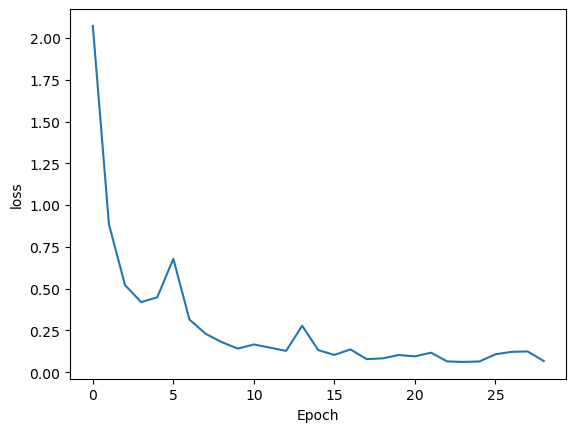

In [111]:
# ---------------- 在測試資料集上預測 -------------------
# 計算準確率
test_loss, test_acc = model.evaluate(test_data)
print("測試結果準確率:", test_acc)
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('loss')

## 任務2 時序資料建模

In [76]:
# Importing the libraries
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import mean_squared_error

In [77]:
# ---------------- 讀取資料 -------------------
train_data=pd.read_csv(r"Bike sharing demand(temporal)\train.csv",index_col="datetime",parse_dates=['datetime'])
test_data=pd.read_csv(r"Bike sharing demand(temporal)\test.csv",index_col="datetime",parse_dates=['datetime'])
train_data

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Y_count
datetime,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1
...,...,...,...,...,...,...,...,...,...
2012-10-19 19:00:00,4,0,1,1,22.14,25.760,88,11.0014,232
2012-10-19 20:00:00,4,0,1,1,21.32,25.000,77,12.9980,229
2012-10-19 21:00:00,4,0,1,1,20.50,24.240,77,0.0000,206


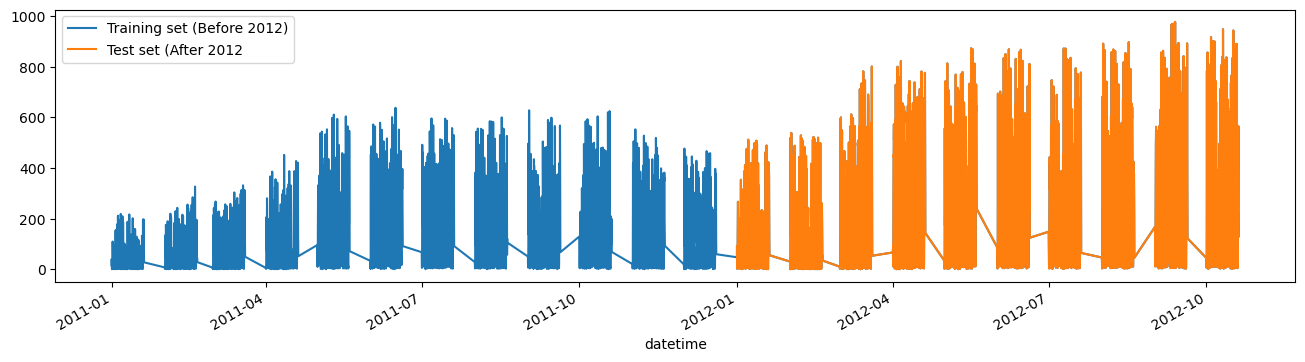

In [78]:
train_data["Y_count"][:'2012'].plot(figsize=(16,4),legend=True)
train_data["Y_count"]['2012':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2012)','Test set (After 2012'])

plt.show()

In [79]:
# ---------------- 資料前處理(此段程式請加註解，並簡短敘述你選擇的時間步長，以及為什麼)-------------------
training_set = train_data.loc[:,['Y_count']].values #切割訓練集Y_count Values
test_set = test_data.loc[:,['Y_count']].values#切割測試集Y_count Values
#正規化
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
#時間步長=48 設定為2天(前48筆資料)，以一天當一個循環，使用兩個循環做預測，資料量也不會太大
time_stamp =48
X_train = []
y_train = []
#加入48筆Y_count作為x以及對應的y_count作為y
for i in range(time_stamp,len(training_set)):
    X_train.append(training_set_scaled[i-time_stamp:i,:])
    y_train.append(training_set_scaled[i,:])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],-1))
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],-1))
dataset = pd.concat([train_data, test_data], axis=0)
tf.data.experimental.enable_debug_mode()

In [82]:
# ---------------- 建立訓練模型 -------------------
# The LSTM architecture
model = Sequential()
# First LSTM layer with Dropout regularisation
model.add(LSTM(units=40, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
# Second LSTM layer
model.add(LSTM(units=40, return_sequences=True))
model.add(Dropout(0.2))
# Third LSTM layer
model.add(LSTM(units=40, return_sequences=True))
model.add(Dropout(0.2))
# Fourth LSTM layer
model.add(LSTM(units=40))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=1))
# Compiling the LSTM
model.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
model.fit(X_train, y_train, 
     epochs=15, batch_size=64)

Epoch 1/15
156/156 [==============================] - 15s 59ms/step - loss: 0.0257
Epoch 2/15
156/156 [==============================] - 9s 60ms/step - loss: 0.0180
Epoch 3/15
156/156 [==============================] - 8s 48ms/step - loss: 0.0158
Epoch 4/15
156/156 [==============================] - 8s 49ms/step - loss: 0.0149
Epoch 5/15
156/156 [==============================] - 8s 49ms/step - loss: 0.0142
Epoch 6/15
156/156 [==============================] - 8s 48ms/step - loss: 0.0129
Epoch 7/15
156/156 [==============================] - 8s 50ms/step - loss: 0.0118
Epoch 8/15
156/156 [==============================] - 8s 48ms/step - loss: 0.0107
Epoch 9/15
156/156 [==============================] - 8s 50ms/step - loss: 0.0105
Epoch 10/15
156/156 [==============================] - 8s 48ms/step - loss: 0.0096
Epoch 11/15
156/156 [==============================] - 8s 52ms/step - loss: 0.0091
Epoch 12/15
156/156 [==============================] - 8s 49ms/step - loss: 0.0087
Epoch 13/15


29/29 [==============================] - 2s 16ms/step


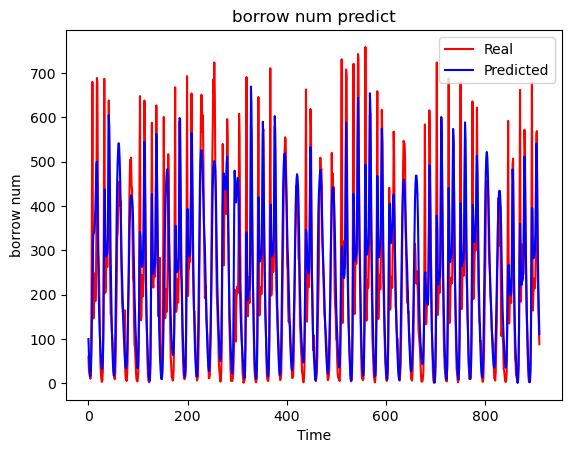

測試結果MSE:8909.90111113225.


In [83]:
# ---------------- 在測試資料集上預測 -------------------
# 製作test資料
dataset_total = dataset.loc[:,['Y_count']].values
inputs = dataset_total[len(training_set) - time_stamp:]
inputs = sc.transform(inputs)
# Preparing X_test and predicting the num
X_test = []
for i in range(time_stamp, len(test_data) + time_stamp):
    X_test.append(inputs[i-time_stamp:i,:])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],-1))

predict = model.predict(X_test)
predict = sc.inverse_transform(predict)
# Visualizing the results for LSTM
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real')
    plt.plot(predicted, color='blue',label='Predicted')
    plt.title('borrow num predict')
    plt.xlabel('Time')
    plt.ylabel('borrow num')
    plt.legend()
    plt.show()
plot_predictions(test_set,predict)
# Evaluating our model
mse = mean_squared_error(test_set, predict)
print("測試結果MSE:{}.".format(mse))

